In [1]:
import sys
import os
import cv2
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from numpy import pi, matmul,sqrt,dot,array,zeros,cos,sin,pi,arccos,arctan
from torch.utils.data import DataLoader
from func import OR,heatplot,calmisorientation,mat2plot, match,imgshow,calpoint,L2,L1,ipfread,misorientation
from Class import Exp,Data,Cluster
import torch.nn.functional as F
import matplotlib.patches as patches
from multiprocessing import Process, Pool
from sklearn.mixture import GaussianMixture
class Dataset(torch.utils.data.Dataset):
    def __init__(self,bef,im,target):
        self.bef=bef
        self.im=im
        self.target=target
    def __getitem__(self,index):
        X=self.bef[index]
        Y=self.target[index]
        im=self.im[index]
        return torch.tensor(X,dtype=torch.float32),torch.tensor(Y,dtype=torch.long),im
    def __len__(self):
        return len(self.bef)
def negsample(corner):
    mat=np.zeros([500,500])
    for (i,j) in corner:
        for k in range(max(0,i-49),min(500,i+50)):
            for l in range(max(0,j-49),min(500,j+50)):
                mat[k,l]=1
    cand = []
    for i in range(451):
        for j in range(451):
            if not mat[i][j]:
                cand.append([i,j])
    return random.sample(cand,len(corner))
def kneigh(bc,k):
    kernel=np.ones([k*2+1,k*2+1])*1/(k*2+1)**2
    bc_=bc.copy()
    h,w=bc.shape
    for i in range(k,h-k):
        for j in range(k,w-k):
            bc_[i,j]=np.sum(kernel*bc[i-k:i+k+1,j-k:j+k+1])
    return bc_

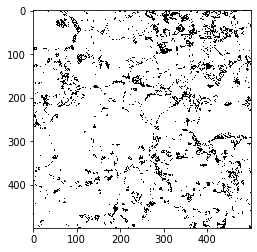

In [2]:
data=Data("data/train/20200916/before/")
ipf=ipfread("data/train/20200916/before/")
orient=data.data["Orient"]
phase=data.data["Phase"]
inv = np.load("new_inv.npy")
h,w=orient.shape[0],orient.shape[1]
bc=data.data["BC"]
plt.imshow(data.data["Phase"],cmap="gray")

In [3]:
neigh=[np.expand_dims(bc,2)]
for i in range(1):
    neigh.append(np.expand_dims(kneigh(bc,i),2))
X = np.concatenate(neigh,axis=2).reshape([h*w,-1])
gm = GaussianMixture(n_components=2, random_state=30,tol=1e-5,reg_covar=1e-3).fit(X)

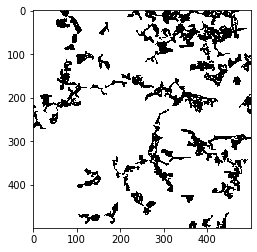

In [4]:
phase=data.data["Phase"]
phase_=data.data["Phase"].copy()
for i in range(1,h-1):
    for j in range(1,w-1):
        if phase[i,j]==0:
            phase_[i-1:i+2,j-1:j+2]=np.zeros([3,3])
plt.imshow(phase_,cmap="gray")
phase=1-phase_
cmap=np.zeros([phase.shape[0],phase.shape[1]]).astype("int")
cluster=dict()
ind = 1
for i in range(phase.shape[0]):
    for j in range(phase.shape[1]):
        if phase[i,j]==1:
            if j>0 and phase[i,j-1]==1:
                cmap[i,j]=cmap[i,j-1]
                cluster[cmap[i,j]].add(i,j)
                if i>0 and phase[i-1,j]==1 and cmap[i,j]!=cmap[i-1,j]:
                    cluster[cmap[i,j]].addn(cmap[i-1,j])
                    cluster[cmap[i-1,j]].addn(cmap[i,j])                    
            elif i>0 and phase[i-1,j]==1:
                cmap[i,j]=cmap[i-1,j]
                cluster[cmap[i,j]].add(i,j)
            else:
                cmap[i,j]=ind
                cluster[ind]=Cluster(ind,i,j)
                ind+=1   
for key in range(1,ind):
    if key in cluster:
        for neigh in cluster[key].neigh.copy():
            cluster[key].merge(neigh,cluster)
crack=[]
phase_aft=np.ones([phase.shape[0],phase.shape[1]])
for key in range(1,ind):
    if key in cluster:
        if cluster[key].num>200:
            for (i,j) in cluster[key].pixels:
                phase_aft[i,j]=0
            crack.append(key)
plt.imshow(phase_aft,cmap="gray")